In [332]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

idx = pd.IndexSlice

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## LOAD RANDOM SEARCH DATA

### Load v3

In [333]:
rs_ver = "rs_v3"
base_path = f"data/ronin/{rs_ver}"

In [334]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [335]:

def make_df(path: str, shift_rep=0):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", _, rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep) + shift_rep
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

dfv3 = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]

dfv3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1500 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 9, 24, 'RouteScenario_735')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1500 non-null   float64
 1   duration_system  1500 non-null   float64
dtypes: float64(2)
memory usage: 55.1+ KB


^ should be 1500 = 25 iter x 10 rep x 2 quality x 3 fps values

### Load v4
and shift repetition number +10

In [336]:
dfs = []
base_path = f"data/ronin/rs_v4"
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file, shift_rep=10))

dfv4 = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
dfv4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2861 entries, (10, 'False', 10, 0, 'RouteScenario_358') to (20, 'True', 28, 16, 'RouteScenario_294')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    2861 non-null   float64
 1   duration_system  2861 non-null   float64
dtypes: float64(2)
memory usage: 85.3+ KB


In [337]:
dfs = []
for rep in [10, 11, 12, 13, 14, 15, 16, 17,  20, 21, 22, 23, 24, 25, 26, 27]:
    s = dfv4.xs(rep, level='rep', drop_level=False)
    dfs.append(s)


dfv4 = pd.concat(dfs, axis=0)
dfv4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2392 entries, (10, 'False', 10, 0, 'RouteScenario_358') to (20, 'True', 27, 24, 'RouteScenario_354')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    2392 non-null   float64
 1   duration_system  2392 non-null   float64
dtypes: float64(2)
memory usage: 75.2+ KB


### Concatonate v3 and v4

In [338]:
df = pd.concat([dfv3, dfv4]).sort_index()
# df = pd.concat([dfv3]).sort_index()
n_reps = df.reset_index()['rep'].nunique()
print(f"Currently we have {n_reps} repetitions")
df.info()

Currently we have 26 repetitions
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3892 entries, (10, 'False', 0, 0, 'RouteScenario_556') to (20, 'True', 27, 24, 'RouteScenario_354')
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    3892 non-null   float64
 1   duration_system  3892 non-null   float64
dtypes: float64(2)
memory usage: 108.1+ KB


## LOAD VERIFICATION DATA

In [339]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [340]:
dfs = []
base_path = f"data/ronin/rs_v3"
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
oracle_df

,oracle_dscore
route_id,
RouteScenario_0,0.65
RouteScenario_1,0.65
RouteScenario_10,1.00
RouteScenario_100,1.00
RouteScenario_101,0.70
...,...
RouteScenario_95,1.00
RouteScenario_96,1.00
RouteScenario_97,1.00


## PROCESS SOLUTIONS

In [341]:


def get_solutions_of_iteration(curr_it):

    # get slice of data frame from iteration 0 to current iteration
    slice = df.loc[idx[:, :, :, :curr_it+1], :]

    # get index of minumum driving score -> solution
    solutions_idx = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score'].idxmin().rename('solution_idx')

    # get value of minimum driving score
    solutions_score = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score'].min().rename('solution_score')

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

In [342]:
# get_solutions_of_iteration(5)

In [343]:
NUM_OF_ITERAITON = 25

sols_df = pd.concat([get_solutions_of_iteration(it)
                    for it in range(NUM_OF_ITERAITON)], axis=0)

# at what iteration did we find the solution
sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
# what is the route_id of the solution
sols_df['solution_route_id'] = sols_df['solution_idx'].apply(lambda x: x[-1])

# we don't need that once unpacked
sols_df = sols_df.drop('solution_idx', axis=1)

# add data from verification
sols_df = sols_df.join(oracle_df, on='solution_route_id')
sols_df = sols_df.sort_index()
sols_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3900 entries, (10, 'False', 0, 0) to (20, 'True', 27, 24)
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   solution_score     3900 non-null   float64
 1   solution_it        3900 non-null   int64  
 2   solution_route_id  3900 non-null   object 
 3   oracle_dscore      3900 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 139.6+ KB


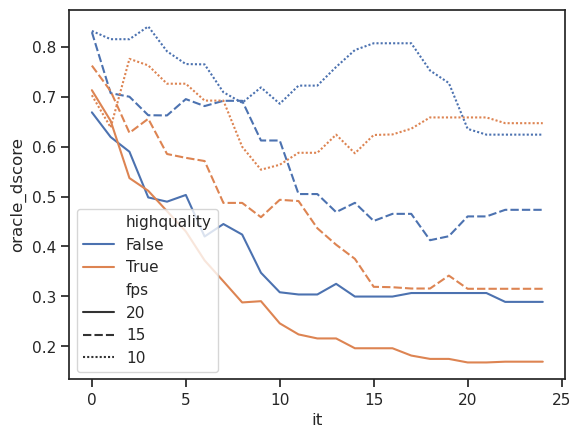

In [344]:
f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

ax = sns.lineplot(data=sols_df, x='it', y='oracle_dscore', style_order=[20, 15, 10],
                  style='fps', hue='highquality', ax=ax, errorbar=None)

In [345]:
cumulative_time = df.groupby(['fps', 'highquality', 'rep'])[
    'duration_system'].cumsum()
cumulative_time = cumulative_time.rename(
    'cumulative_time').to_frame().droplevel('route_id')

sols_df = sols_df.join(cumulative_time)

In [346]:
sols_df

solution_score  solution_it  solution_route_id  oracle_dscore  cumulative_time
fps highquality rep it                                                                                
10  False       0   0         0.096086            1  RouteScenario_461       0.700000       514.576038
                    1         0.055417            2    RouteScenario_4       1.000000      1225.405219
                    2         0.055417            2    RouteScenario_4       1.000000      1737.925832
                    3         0.055417            2    RouteScenario_4       1.000000      2002.960191
                    4         0.055417            2    RouteScenario_4       1.000000      2627.114673
...                                ...          ...                ...            ...              ...
20  True        27  20        0.260527            5  RouteScenario_592       0.260527     12315.057038
                    21        0.260527            5  RouteScenario_592       0.260527     14121.333701
                    22        0.260527            5  RouteScenario_592       0.260527     14485.275092
                    23        0.260527            5  RouteScenario_592       0.260527     14832.957040
                    24        0.260527            5  RouteScenario_592       0.260527     15282.194089

[3900 rows x 5 columns]

In [347]:
# aggregate mean across repetitions so it can be ploted nicely
data = sols_df[['oracle_dscore', 'cumulative_time', 'solution_score']
               ].groupby(['fps', 'highquality', 'it']).mean()

# data

In [348]:
data.index = data.index.set_levels(data.index.levels[0].astype(str), level=0)
data = data.sort_index(ascending=False)
data.head()

oracle_dscore  cumulative_time  solution_score
fps highquality it                                                
20  True        24       0.168891     17682.802878        0.139866
                23       0.168891     17149.135233        0.139866
                22       0.168891     16548.533094        0.139866
                21       0.167353     15878.100692        0.149581
                20       0.167353     15059.079875        0.149581

## PLOT Oracle DScore

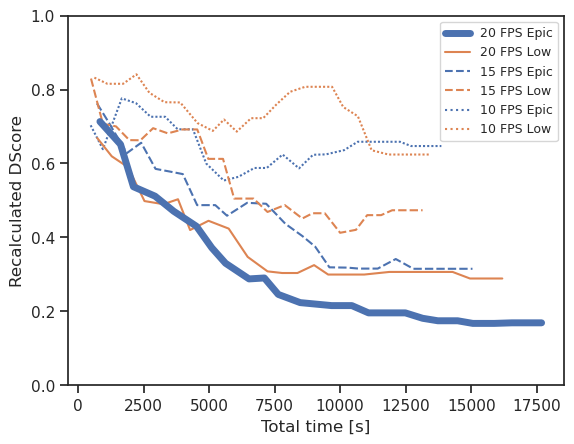

In [349]:
sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

sns.lineplot(data=data, x='cumulative_time', y='oracle_dscore',
             style='fps', hue='highquality', ax=ax, errorbar=None)

sns.lineplot(data=data.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
             y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)


ax.set_ylabel("Recalculated DScore")
ax.set_xlabel("Total time [s]")
ax.set_ylim(0, 1)

# BETTER LEGEND
handles, labels = ax.get_legend_handles_labels()

blue = handles[1].get_color()
orange = handles[2].get_color()
lines = [
    mlines.Line2D([], [], color=blue, linestyle=None,
                  label='20 FPS Epic', lw=5),
    mlines.Line2D([], [], color=orange, linestyle=None, label='20 FPS Low'),

    mlines.Line2D([], [], color=blue, linestyle='--', label='15 FPS Epic'),
    mlines.Line2D([], [], color=orange, linestyle='--', label='15 FPS Low'),
    mlines.Line2D([], [], color=blue, linestyle='dotted',
                  label='10 FPS Epic'),
    mlines.Line2D([], [], color=orange,
                  linestyle='dotted', label='10 FPS Low'),

]

ax.legend(handles=lines, prop={'size': 9})

f.savefig('rq3.pdf', bbox_inches='tight')

## PLOT low-fid Dscore

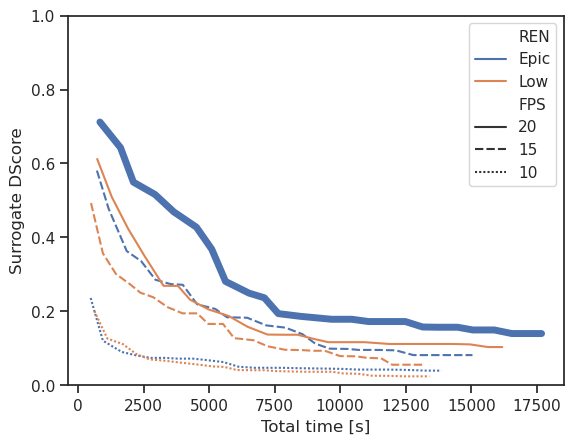

In [350]:
sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

sns.lineplot(data=data, x='cumulative_time', y='solution_score',
             style='fps', hue='highquality', ax=ax, errorbar=None)

sns.lineplot(data=data.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
             y='solution_score', hue='highquality', ax=ax,  errorbar=None, lw=5)


ax.set_ylabel("Surrogate DScore")
ax.set_xlabel("Total time [s]")
ax.set_ylim(0, 1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[
          'REN', 'Epic', 'Low', 'FPS', '20', '15', '10'])

## Statistical tests

In [351]:
from scipy.stats import mannwhitneyu
from itertools import permutations

ITERATION = 0

In [352]:


def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.99):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tAt {ITERATION = } the difference beetween {fid_a} and {fid_b} IS statistically significant. {p = :.5f}")
        print(set_a)
        print(set_b)
    else:
        return
        print(
            f"\tAt {ITERATION = } the difference beetween {fid_a} and {fid_b} is NOT statistically significant. {p = :.5f}")

In [353]:
#
oracle_dscores = sols_df.loc[idx[:, :, :, ITERATION]]['oracle_dscore'].groupby(
    ['fps', 'highquality',]).agg(list)

In [354]:
# iterate over all possible fidelities
for (a_fid, a_list), (b_fid, b_list) in permutations(oracle_dscores.items(), 2):
    do_test(a_fid, b_fid, a_list, b_list)

	At ITERATION = 0 the difference beetween (10, 'False') and (10, 'True') is NOT statistically significant. p = 0.26387
	At ITERATION = 0 the difference beetween (10, 'False') and (15, 'False') is NOT statistically significant. p = 0.68199
	At ITERATION = 0 the difference beetween (10, 'False') and (15, 'True') is NOT statistically significant. p = 0.45119
	At ITERATION = 0 the difference beetween (10, 'False') and (20, 'False') is NOT statistically significant. p = 0.03451
	At ITERATION = 0 the difference beetween (10, 'False') and (20, 'True') is NOT statistically significant. p = 0.09055
	At ITERATION = 0 the difference beetween (10, 'True') and (10, 'False') is NOT statistically significant. p = 0.26387
	At ITERATION = 0 the difference beetween (10, 'True') and (15, 'False') is NOT statistically significant. p = 0.17356
	At ITERATION = 0 the difference beetween (10, 'True') and (15, 'True') is NOT statistically significant. p = 0.57382
	At ITERATION = 0 the difference beetween (10, 

## Total time

In [355]:
n_rows = df['duration_system'].index.size
n_rows

3892

In [356]:
total_hours = df['duration_system'].sum() / 3600
total_hours

643.8439529218276